# Brain Tumor Detection

In [ ]:
import os
import cv2
import glob
import imutils
import numpy as np
import pandas as pd
import seaborn as sns
import tensorflow as tf
from pathlib import Path
from keras import regularizers
import matplotlib.pyplot as plt
from keras.optimizers import RMSprop
from sklearn.metrics import confusion_matrix
from tensorflow.keras.models import Sequential
from sklearn.model_selection import train_test_split
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from keras.layers import Dense, Dropout, Flatten, Conv2D, MaxPool2D

In [ ]:
brain_tumor_data_no = Path("./dataset/no")
brain_tumor_data_yes = Path("./dataset/yes")

# Ensure all the files are of type `.jpg`
brain_tumor_data_no_jpg = list(brain_tumor_data_no.glob(r"*.jpg"))
brain_tumor_data_yes_jpg = list(brain_tumor_data_yes.glob(r"*.jpg"))

Tumorous 1500
Non Tumorous 1500


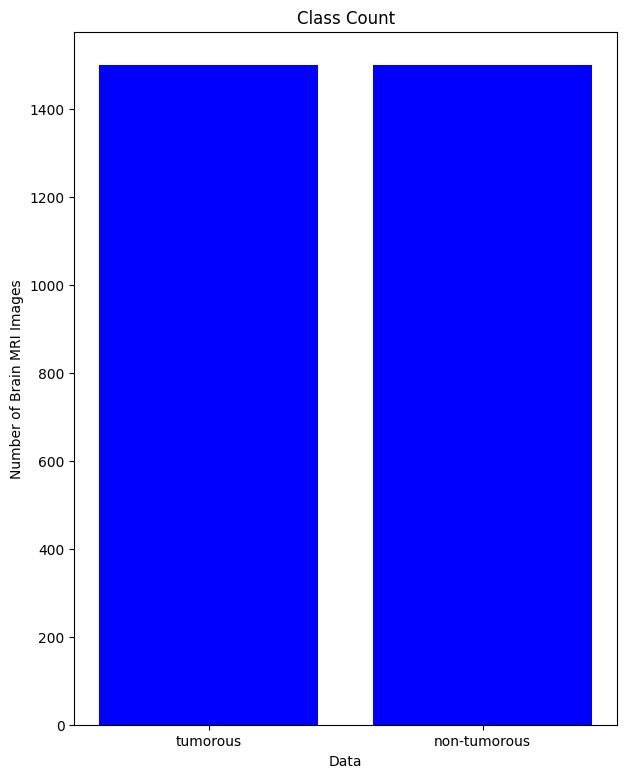

In [ ]:
# Check for class imbalance

no_of_non_tumorous = len(brain_tumor_data_no_jpg)
no_of_tumorous = len(brain_tumor_data_yes_jpg)


print("Tumorous", no_of_tumorous)
print("Non Tumorous", no_of_non_tumorous)


data = {
    'tumorous': no_of_tumorous,
    'non-tumorous': no_of_non_tumorous,
}

types = data.keys()
values = data.values()

fig = plt.figure(figsize=(7, 9))

plt.bar(types, values, color="blue")
plt.xlabel("Data")
plt.ylabel("Number of Brain MRI Images")
plt.title("Class Count")
plt.show()

In [ ]:
brain_tumor_data_all = brain_tumor_data_no_jpg + brain_tumor_data_yes_jpg

In [ ]:
MRI_images_labels = list(
    map(
        lambda x: os.path.split(
            os.path.split(x)[0]
        )[1],
        brain_tumor_data_all
    )
)

In [ ]:
print("First Five: ", MRI_images_labels[0:5])
print("Last Five: ", MRI_images_labels[-5:])

First Five:  ['no', 'no', 'no', 'no', 'no']
Last Five:  ['yes', 'yes', 'yes', 'yes', 'yes']


In [ ]:
brain_tumor_data_series = pd.Series(brain_tumor_data_all,name="JPG").astype(str)
MRI_images_labels_series = pd.Series(MRI_images_labels,name="TUMOR_CATEGORY")


Main_Train_Data = pd.concat([brain_tumor_data_series, MRI_images_labels_series],axis=1)
print(Main_Train_Data.head())
print("-" * 45)
print(Main_Train_Data.tail())

                    JPG TUMOR_CATEGORY
0  dataset/no/no861.jpg             no
1  dataset/no/no214.jpg             no
2   dataset/no/no26.jpg             no
3  dataset/no/no368.jpg             no
4  dataset/no/no450.jpg             no
---------------------------------------------
                        JPG TUMOR_CATEGORY
2995   dataset/yes/y644.jpg            yes
2996  dataset/yes/y1179.jpg            yes
2997  dataset/yes/y1463.jpg            yes
2998  dataset/yes/y1203.jpg            yes
2999   dataset/yes/y319.jpg            yes


In [ ]:
brain_tumor_data_pred = Path("./dataset/pred")
Test_Images_Path = list(brain_tumor_data_pred.glob(r"*.jpg"))

In [ ]:
Test_Images_Labels = list(
    map(
        lambda x: os.path.split(os.path.split(x)[0]
    )[1],
    Test_Images_Path)
)

In [ ]:
Test_Images_Path_Series = pd.Series( Test_Images_Path, name="JPG").astype(str)
Test_Images_Labels_Series = pd.Series(Test_Images_Labels,name="TUMOR_CATEGORY")

Test_Data = pd.concat([Test_Images_Path_Series,Test_Images_Labels_Series],axis=1)

print(Test_Data.head(10))

                       JPG TUMOR_CATEGORY
0  dataset/pred/pred46.jpg           pred
1   dataset/pred/pred9.jpg           pred
2  dataset/pred/pred17.jpg           pred
3   dataset/pred/pred8.jpg           pred
4   dataset/pred/pred1.jpg           pred
5  dataset/pred/pred31.jpg           pred
6  dataset/pred/pred42.jpg           pred
7  dataset/pred/pred32.jpg           pred
8  dataset/pred/pred49.jpg           pred
9  dataset/pred/pred44.jpg           pred


### Let's shuffle the dataset

In [ ]:
Main_Train_Data = Main_Train_Data.sample(frac=1).reset_index(drop=True)

In [ ]:
print(Main_Train_Data.head(-1))

                        JPG TUMOR_CATEGORY
0      dataset/yes/y843.jpg            yes
1     dataset/yes/y1488.jpg            yes
2      dataset/no/no186.jpg             no
3      dataset/no/no172.jpg             no
4      dataset/no/no166.jpg             no
...                     ...            ...
2994  dataset/no/no1045.jpg             no
2995   dataset/yes/y340.jpg            yes
2996   dataset/no/no855.jpg             no
2997   dataset/yes/y960.jpg            yes
2998  dataset/no/no1121.jpg             no

[2999 rows x 2 columns]


# Image Data Preprocessing


In [ ]:
def crop_brain_tumor(image, plot=False):
    gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    gray = cv2.GaussianBlur(gray, (5,5), 0)

    thres = cv2.threshold(gray, 45, 255, cv2.THRESH_BINARY)[1]
    thres =cv2.erode(thres, None, iterations = 2)
    thres = cv2.dilate(thres, None, iterations = 2)

    cnts = cv2.findContours(thres.copy(), cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    cnts = imutils.grab_contours(cnts)
    c = max(cnts, key = cv2.contourArea)

    extLeft = tuple(c[c[:,:,0].argmin()][0])
    extRight = tuple(c[c[:,:,0].argmax()][0])
    extTop = tuple(c[c[:,:,1].argmin()][0])
    extBot = tuple(c[c[:,:,1].argmax()][0])

    new_image = image[extTop[1]:extBot[1], extLeft[0]:extRight[0]]

    if plot:
        plt.figure(figsize=(5,5))
        plt.subplot(1, 2, 1)
        plt.imshow(image)

        plt.tick_params(axis='both', which='both',
                        top=False, bottom=False, left=False, right=False,
                        labelbottom=False, labeltop=False, labelleft=False, labelright=False)

        plt.title('Original Image')

        plt.subplot(1, 2, 2)
        plt.imshow(new_image)

        plt.tick_params(axis='both', which='both',
                        top=False, bottom=False, left=False, right=False,
                        labelbottom=False, labeltop=False, labelleft=False, labelright=False)

        plt.title('Cropped Image')
        plt.show()
    return new_image

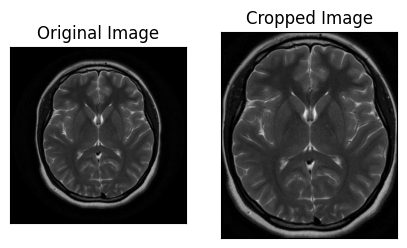

array([[[0, 0, 0],
        [0, 0, 0],
        [0, 0, 0],
        ...,
        [0, 0, 0],
        [0, 0, 0],
        [0, 0, 0]],

       [[0, 0, 0],
        [0, 0, 0],
        [0, 0, 0],
        ...,
        [0, 0, 0],
        [0, 0, 0],
        [0, 0, 0]],

       [[0, 0, 0],
        [0, 0, 0],
        [0, 0, 0],
        ...,
        [0, 0, 0],
        [0, 0, 0],
        [0, 0, 0]],

       ...,

       [[0, 0, 0],
        [0, 0, 0],
        [0, 0, 0],
        ...,
        [0, 0, 0],
        [0, 0, 0],
        [0, 0, 0]],

       [[0, 0, 0],
        [0, 0, 0],
        [0, 0, 0],
        ...,
        [0, 0, 0],
        [0, 0, 0],
        [0, 0, 0]],

       [[0, 0, 0],
        [0, 0, 0],
        [0, 0, 0],
        ...,
        [0, 0, 0],
        [0, 0, 0],
        [0, 0, 0]]], dtype=uint8)
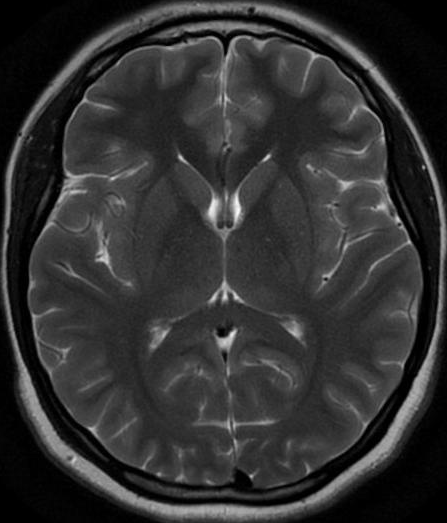

In [ ]:
image = cv2.imread(Main_Train_Data["JPG"][10])
crop_brain_tumor(image, True)

In [ ]:
# Crop the Images to remove the excess black backgrounds (Main Data)

for filename in Main_Train_Data.iloc[:, 0].tolist():
    img = cv2.imread(filename)
    img = crop_brain_tumor(img, False)
    cv2.imwrite(filename, img)

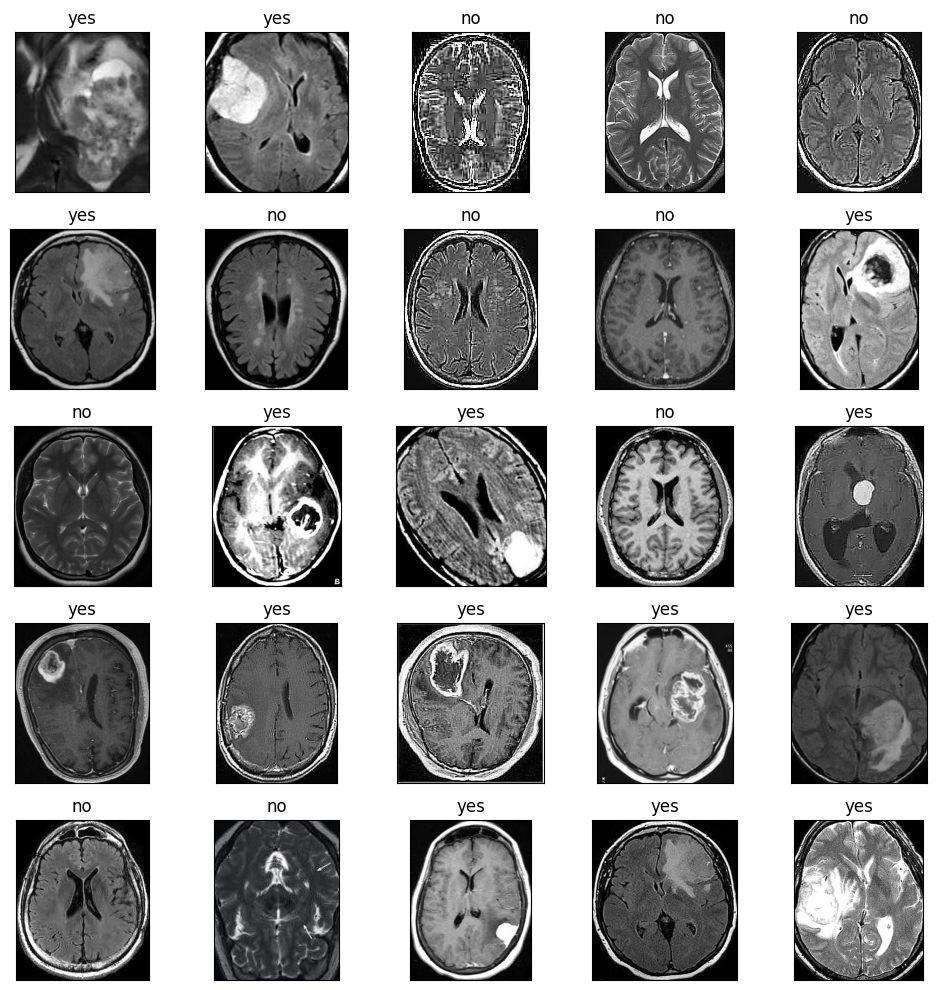

In [ ]:
fig, axes = plt.subplots(nrows=5, ncols=5, figsize=(10, 10),
                        subplot_kw={'xticks': [], 'yticks': []})

for i, ax in enumerate(axes.flat):
    ax.imshow(plt.imread(Main_Train_Data["JPG"][i]))
    ax.set_title(Main_Train_Data["TUMOR_CATEGORY"][i])
plt.tight_layout()
plt.show()

In [ ]:
# Crop the Images to remove the excess black backgrounds (Pred Data)

for filename in Test_Data.iloc[:, 0].tolist():
    img = cv2.imread(filename)
    img = crop_brain_tumor(img, False)
    cv2.imwrite(filename, img)

In [ ]:
# Split the data
train_data, test_data = train_test_split(Main_Train_Data,train_size=0.9,random_state=42)

In [ ]:
print(train_data.shape)

(2700, 2)


In [ ]:
print(train_data.head())

                        JPG TUMOR_CATEGORY
433    dataset/no/no169.jpg             no
1151  dataset/yes/y1345.jpg            yes
73    dataset/no/no1344.jpg             no
1536    dataset/yes/y97.jpg            yes
2709   dataset/no/no481.jpg             no


In [ ]:
print(test_data.shape)

(300, 2)


In [ ]:
print(test_data.head())

                        JPG TUMOR_CATEGORY
1801  dataset/yes/y1030.jpg            yes
1190   dataset/yes/y754.jpg            yes
1817  dataset/no/no1086.jpg             no
251    dataset/yes/y392.jpg            yes
2505     dataset/yes/y0.jpg            yes


# IMAGE DATA GENERATOR

In [ ]:
Data_Generator = ImageDataGenerator(rescale=1./255,brightness_range=[0.3,0.9],
                                       rotation_range=30,
                                       width_shift_range=0.2,
                                       height_shift_range=0.2,
                                       shear_range=0.2,
                                       horizontal_flip=True,
                                       fill_mode="nearest",
                                       validation_split=0.1)

In [ ]:
Train_Set = Data_Generator.flow_from_dataframe(dataframe=train_data,
                                               x_col="JPG",
                                               y_col="TUMOR_CATEGORY",
                                               color_mode="grayscale",
                                               class_mode="categorical",
                                               subset="training",
                                               batch_size=20,
                                               target_size=(200,200))

Found 2430 validated image filenames belonging to 2 classes.


In [ ]:
Validation_Set = Data_Generator.flow_from_dataframe(dataframe=train_data,
                                                     x_col="JPG",
                                                     y_col="TUMOR_CATEGORY",
                                                     color_mode="grayscale",
                                                     class_mode="categorical",
                                                     subset="validation",
                                                     batch_size=20,
                                                     target_size=(200,200))

Found 270 validated image filenames belonging to 2 classes.


In [ ]:
Test_Set = Data_Generator.flow_from_dataframe(dataframe=test_data,
                                              x_col="JPG",
                                              y_col="TUMOR_CATEGORY",
                                              color_mode="grayscale",
                                              class_mode="categorical",
                                              batch_size=20,
                                              target_size=(200,200))

Found 300 validated image filenames belonging to 2 classes.


#### CHECKING

In [ ]:
for data_batch,label_batch in Train_Set:
    print("DATA SHAPE: ",data_batch.shape)
    print("LABEL SHAPE: ",label_batch.shape)
    break

DATA SHAPE:  (20, 200, 200, 1)
LABEL SHAPE:  (20, 2)


In [ ]:
for data_batch,label_batch in Validation_Set:
    print("DATA SHAPE: ",data_batch.shape)
    print("LABEL SHAPE: ",label_batch.shape)
    break

DATA SHAPE:  (20, 200, 200, 1)
LABEL SHAPE:  (20, 2)


In [ ]:
for data_batch,label_batch in Test_Set:
    print("DATA SHAPE: ",data_batch.shape)
    print("LABEL SHAPE: ",label_batch.shape)
    break

DATA SHAPE:  (20, 200, 200, 1)
LABEL SHAPE:  (20, 2)


In [ ]:
print(Train_Set.class_indices)
print(Train_Set.classes[0:5])
print(Train_Set.image_shape)

{'no': 0, 'yes': 1}
[1, 0, 1, 0, 1]
(200, 200, 1)


In [ ]:
print(Validation_Set.class_indices)
print(Validation_Set.classes[0:5])
print(Validation_Set.image_shape)

{'no': 0, 'yes': 1}
[0, 1, 0, 1, 0]
(200, 200, 1)


In [ ]:
print(Test_Set.class_indices)
print(Test_Set.classes[0:5])
print(Test_Set.image_shape)

{'no': 0, 'yes': 1}
[1, 1, 0, 1, 1]
(200, 200, 1)


#### MODEL STRUCTURE

In [ ]:
Model = Sequential()

Model.add(Conv2D(32,(5,5),activation="relu",input_shape=(200,200,1)))
Model.add(MaxPool2D((2,2)))
Model.add(Dropout(0.2))
#
Model.add(Conv2D(64,(3,3),activation="relu"))
Model.add(MaxPool2D((2,2)))
Model.add(Dropout(0.2))
#
Model.add(Conv2D(128,(3,3),activation="relu"))
Model.add(MaxPool2D((2,2)))
Model.add(Dropout(0.2))
#
Model.add(Conv2D(256,(3,3),activation="relu"))
Model.add(MaxPool2D((2,2)))
Model.add(Dropout(0.2))
#
Model.add(Flatten())
Model.add(Dropout(0.5))
Model.add(Dense(512,activation="relu"))
Model.add(Dense(2,activation="softmax"))

/usr/local/lib/python3.11/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


#### MODEL COMPILE

In [ ]:
Model.compile(optimizer=RMSprop(learning_rate=0.001),loss="categorical_crossentropy",metrics=["accuracy"])

In [ ]:
early_stopping = EarlyStopping(monitor="val_loss", mode="min", patience=10, verbose=1)

#### MODEL FITTING

In [ ]:
model_1 = Model.fit(
    Train_Set,
    validation_data=Validation_Set,
    epochs=50,
    steps_per_epoch=120,
    callbacks=[early_stopping]
)

/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/50
120/120 ━━━━━━━━━━━━━━━━━━━━ 217s 2s/step - accuracy: 0.4927 - loss: 0.8901 - val_accuracy: 0.5333 - val_loss: 0.6880
Epoch 2/50
  2/120 ━━━━━━━━━━━━━━━━━━━━ 3:33 2s/step - accuracy: 0.5125 - loss: 0.6860

/usr/local/lib/python3.11/dist-packages/keras/src/trainers/epoch_iterator.py:107: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self._interrupted_warning()


120/120 ━━━━━━━━━━━━━━━━━━━━ 10s 67ms/step - accuracy: 0.5248 - loss: 0.6828 - val_accuracy: 0.5074 - val_loss: 0.6930
Epoch 3/50
120/120 ━━━━━━━━━━━━━━━━━━━━ 214s 2s/step - accuracy: 0.5596 - loss: 0.6898 - val_accuracy: 0.5222 - val_loss: 0.6912
Epoch 4/50
120/120 ━━━━━━━━━━━━━━━━━━━━ 9s 64ms/step - accuracy: 0.6752 - loss: 0.6697 - val_accuracy: 0.5593 - val_loss: 0.6842
Epoch 5/50
120/120 ━━━━━━━━━━━━━━━━━━━━ 203s 2s/step - accuracy: 0.5524 - loss: 0.6877 - val_accuracy: 0.6037 - val_loss: 0.6671
Epoch 6/50
120/120 ━━━━━━━━━━━━━━━━━━━━ 9s 65ms/step - accuracy: 0.6744 - loss: 0.6358 - val_accuracy: 0.5963 - val_loss: 0.6592
Epoch 7/50
120/120 ━━━━━━━━━━━━━━━━━━━━ 256s 2s/step - accuracy: 0.5993 - loss: 0.6769 - val_accuracy: 0.5630 - val_loss: 0.6604
Epoch 8/50
120/120 ━━━━━━━━━━━━━━━━━━━━ 9s 60ms/step - accuracy: 0.6252 - loss: 0.6516 - val_accuracy: 0.5778 - val_loss: 0.6557
Epoch 9/50
120/120 ━━━━━━━━━━━━━━━━━━━━ 248s 2s/step - accuracy: 0.6083 - loss: 0.6651 - val_accuracy: 0.67

#### MODEL SUMMARY

In [ ]:
print(Model.summary())

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                      │ (None, 196, 196, 32)        │             832 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d (MaxPooling2D)         │ (None, 98, 98, 32)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ (None, 98, 98, 32)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_1 (Conv2D)                    │ (None, 96, 96, 64)          │          18,496 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_1 (MaxPooling2D)       │ (None, 48, 48, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_1 (Dropout)                  │ (None, 48, 48, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_2 (Conv2D)                    │ (None, 46, 46, 128)         │          73,856 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_2 (MaxPooling2D)       │ (None, 23, 23, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_2 (Dropout)                  │ (None, 23, 23, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_3 (Conv2D)                    │ (None, 21, 21, 256)         │         295,168 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_3 (MaxPooling2D)       │ (None, 10, 10, 256)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_3 (Dropout)                  │ (None, 10, 10, 256)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten (Flatten)                    │ (None, 25600)               │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_4 (Dropout)                  │ (None, 25600)               │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 512)                 │      13,107,712 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 2)                   │           1,026 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 26,994,182 (102.97 MB)

 Trainable params: 13,497,090 (51.49 MB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 13,497,092 (51.49 MB)

None


In [ ]:
# Save the model

Model.save("model_3.keras")

### Visualizations

In [ ]:
HistoryDict = model_1.history

val_losses = HistoryDict["val_loss"]
val_acc = HistoryDict["val_accuracy"]
acc = HistoryDict["accuracy"]
losses = HistoryDict["loss"]
epochs = range(1,len(val_losses)+1)

<ipython-input-94-33946ec0fa8a>:4: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend()


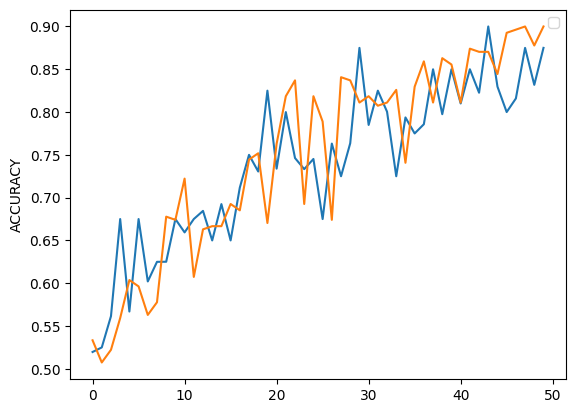

In [ ]:
plt.plot(model_1.history["accuracy"])
plt.plot(model_1.history["val_accuracy"])
plt.ylabel("ACCURACY")
plt.legend()
plt.show()

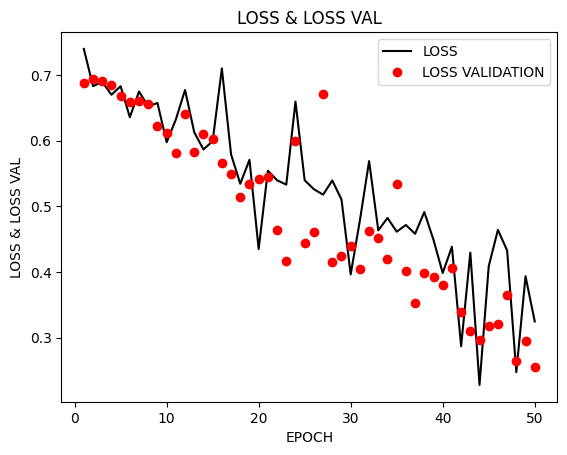

In [ ]:
plt.plot(epochs,losses,"k-",label="LOSS")
plt.plot(epochs,val_losses,"ro",label="LOSS VALIDATION")
plt.title("LOSS & LOSS VAL")
plt.xlabel("EPOCH")
plt.ylabel("LOSS & LOSS VAL")
plt.legend()
plt.show()

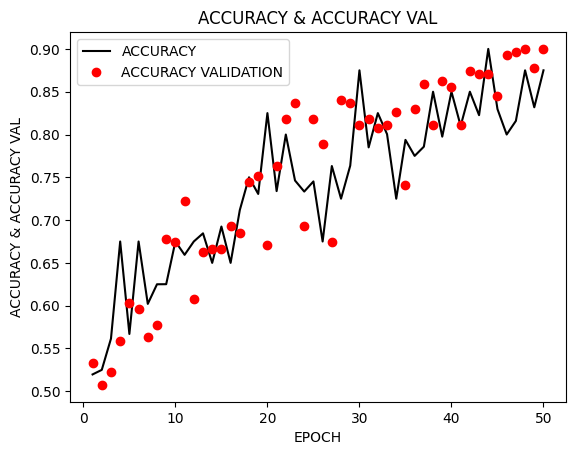

In [ ]:
plt.plot(epochs,acc,"k-",label="ACCURACY")
plt.plot(epochs,val_acc,"ro",label="ACCURACY VALIDATION")
plt.title("ACCURACY & ACCURACY VAL")
plt.xlabel("EPOCH")
plt.ylabel("ACCURACY & ACCURACY VAL")
plt.legend()
plt.show()

<Axes: >

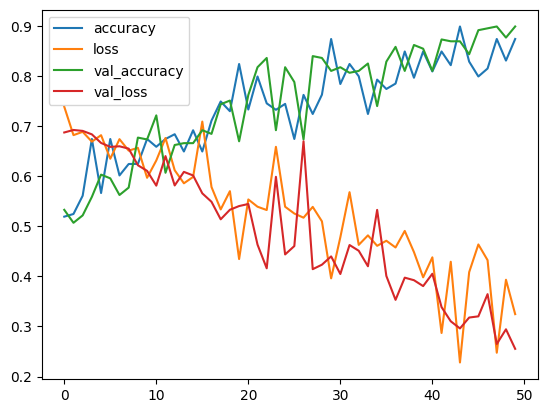

In [ ]:
Dict_Summary = pd.DataFrame(model_1.history)
Dict_Summary.plot()

#### PREDICTION SCORE ON DIVIDED DATA

In [ ]:
Model_Results = Model.evaluate(Test_Set,verbose=False)
print("LOSS:  " + "%.4f" % Model_Results[0])
print("ACCURACY:  " + "%.2f" % Model_Results[1])

/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


LOSS:  0.3358
ACCURACY:  0.86


#### PREDICTION PROCESS

In [ ]:
Main_Data_Prediction = pd.DataFrame({"JPG":Test_Images_Path_Series})

In [ ]:
print(Main_Data_Prediction.head())

                       JPG
0  dataset/pred/pred46.jpg
1   dataset/pred/pred9.jpg
2  dataset/pred/pred17.jpg
3   dataset/pred/pred8.jpg
4   dataset/pred/pred1.jpg


In [ ]:
Main_Test_Generator = ImageDataGenerator(rescale=1./255)

In [ ]:
Main_Test_Set = Main_Test_Generator.flow_from_dataframe(dataframe=Main_Data_Prediction,
                                                       x_col="JPG",
                                                       y_col=None,
                                                       color_mode="grayscale",
                                                        class_mode=None,
                                                        batch_size=20,
                                                        target_size=(200,200))

Found 60 validated image filenames.


In [ ]:
Model_Test_Prediction = Model.predict(Main_Test_Set)

/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


3/3 ━━━━━━━━━━━━━━━━━━━━ 1s 385ms/step


In [ ]:
Model_Test_Prediction = Model_Test_Prediction.argmax(axis=-1)

In [ ]:
print(Model_Test_Prediction)

[1 0 1 0 1 0 1 0 0 0 0 0 0 0 1 1 0 0 1 0 0 1 0 0 1 0 0 0 0 0 1 1 0 1 1 0 0
 0 1 0 1 0 0 1 1 1 0 0 1 0 0 1 1 0 1 0 0 1 0 1]


In [ ]:
Last_Prediction = []
[Last_Prediction.append('NO') if i == 1 else Last_Prediction.append('TUMOR') for i in Model_Test_Prediction]
print(Last_Prediction)

['NO', 'TUMOR', 'NO', 'TUMOR', 'NO', 'TUMOR', 'NO', 'TUMOR', 'TUMOR', 'TUMOR', 'TUMOR', 'TUMOR', 'TUMOR', 'TUMOR', 'NO', 'NO', 'TUMOR', 'TUMOR', 'NO', 'TUMOR', 'TUMOR', 'NO', 'TUMOR', 'TUMOR', 'NO', 'TUMOR', 'TUMOR', 'TUMOR', 'TUMOR', 'TUMOR', 'NO', 'NO', 'TUMOR', 'NO', 'NO', 'TUMOR', 'TUMOR', 'TUMOR', 'NO', 'TUMOR', 'NO', 'TUMOR', 'TUMOR', 'NO', 'NO', 'NO', 'TUMOR', 'TUMOR', 'NO', 'TUMOR', 'TUMOR', 'NO', 'NO', 'TUMOR', 'NO', 'TUMOR', 'TUMOR', 'NO', 'TUMOR', 'NO']


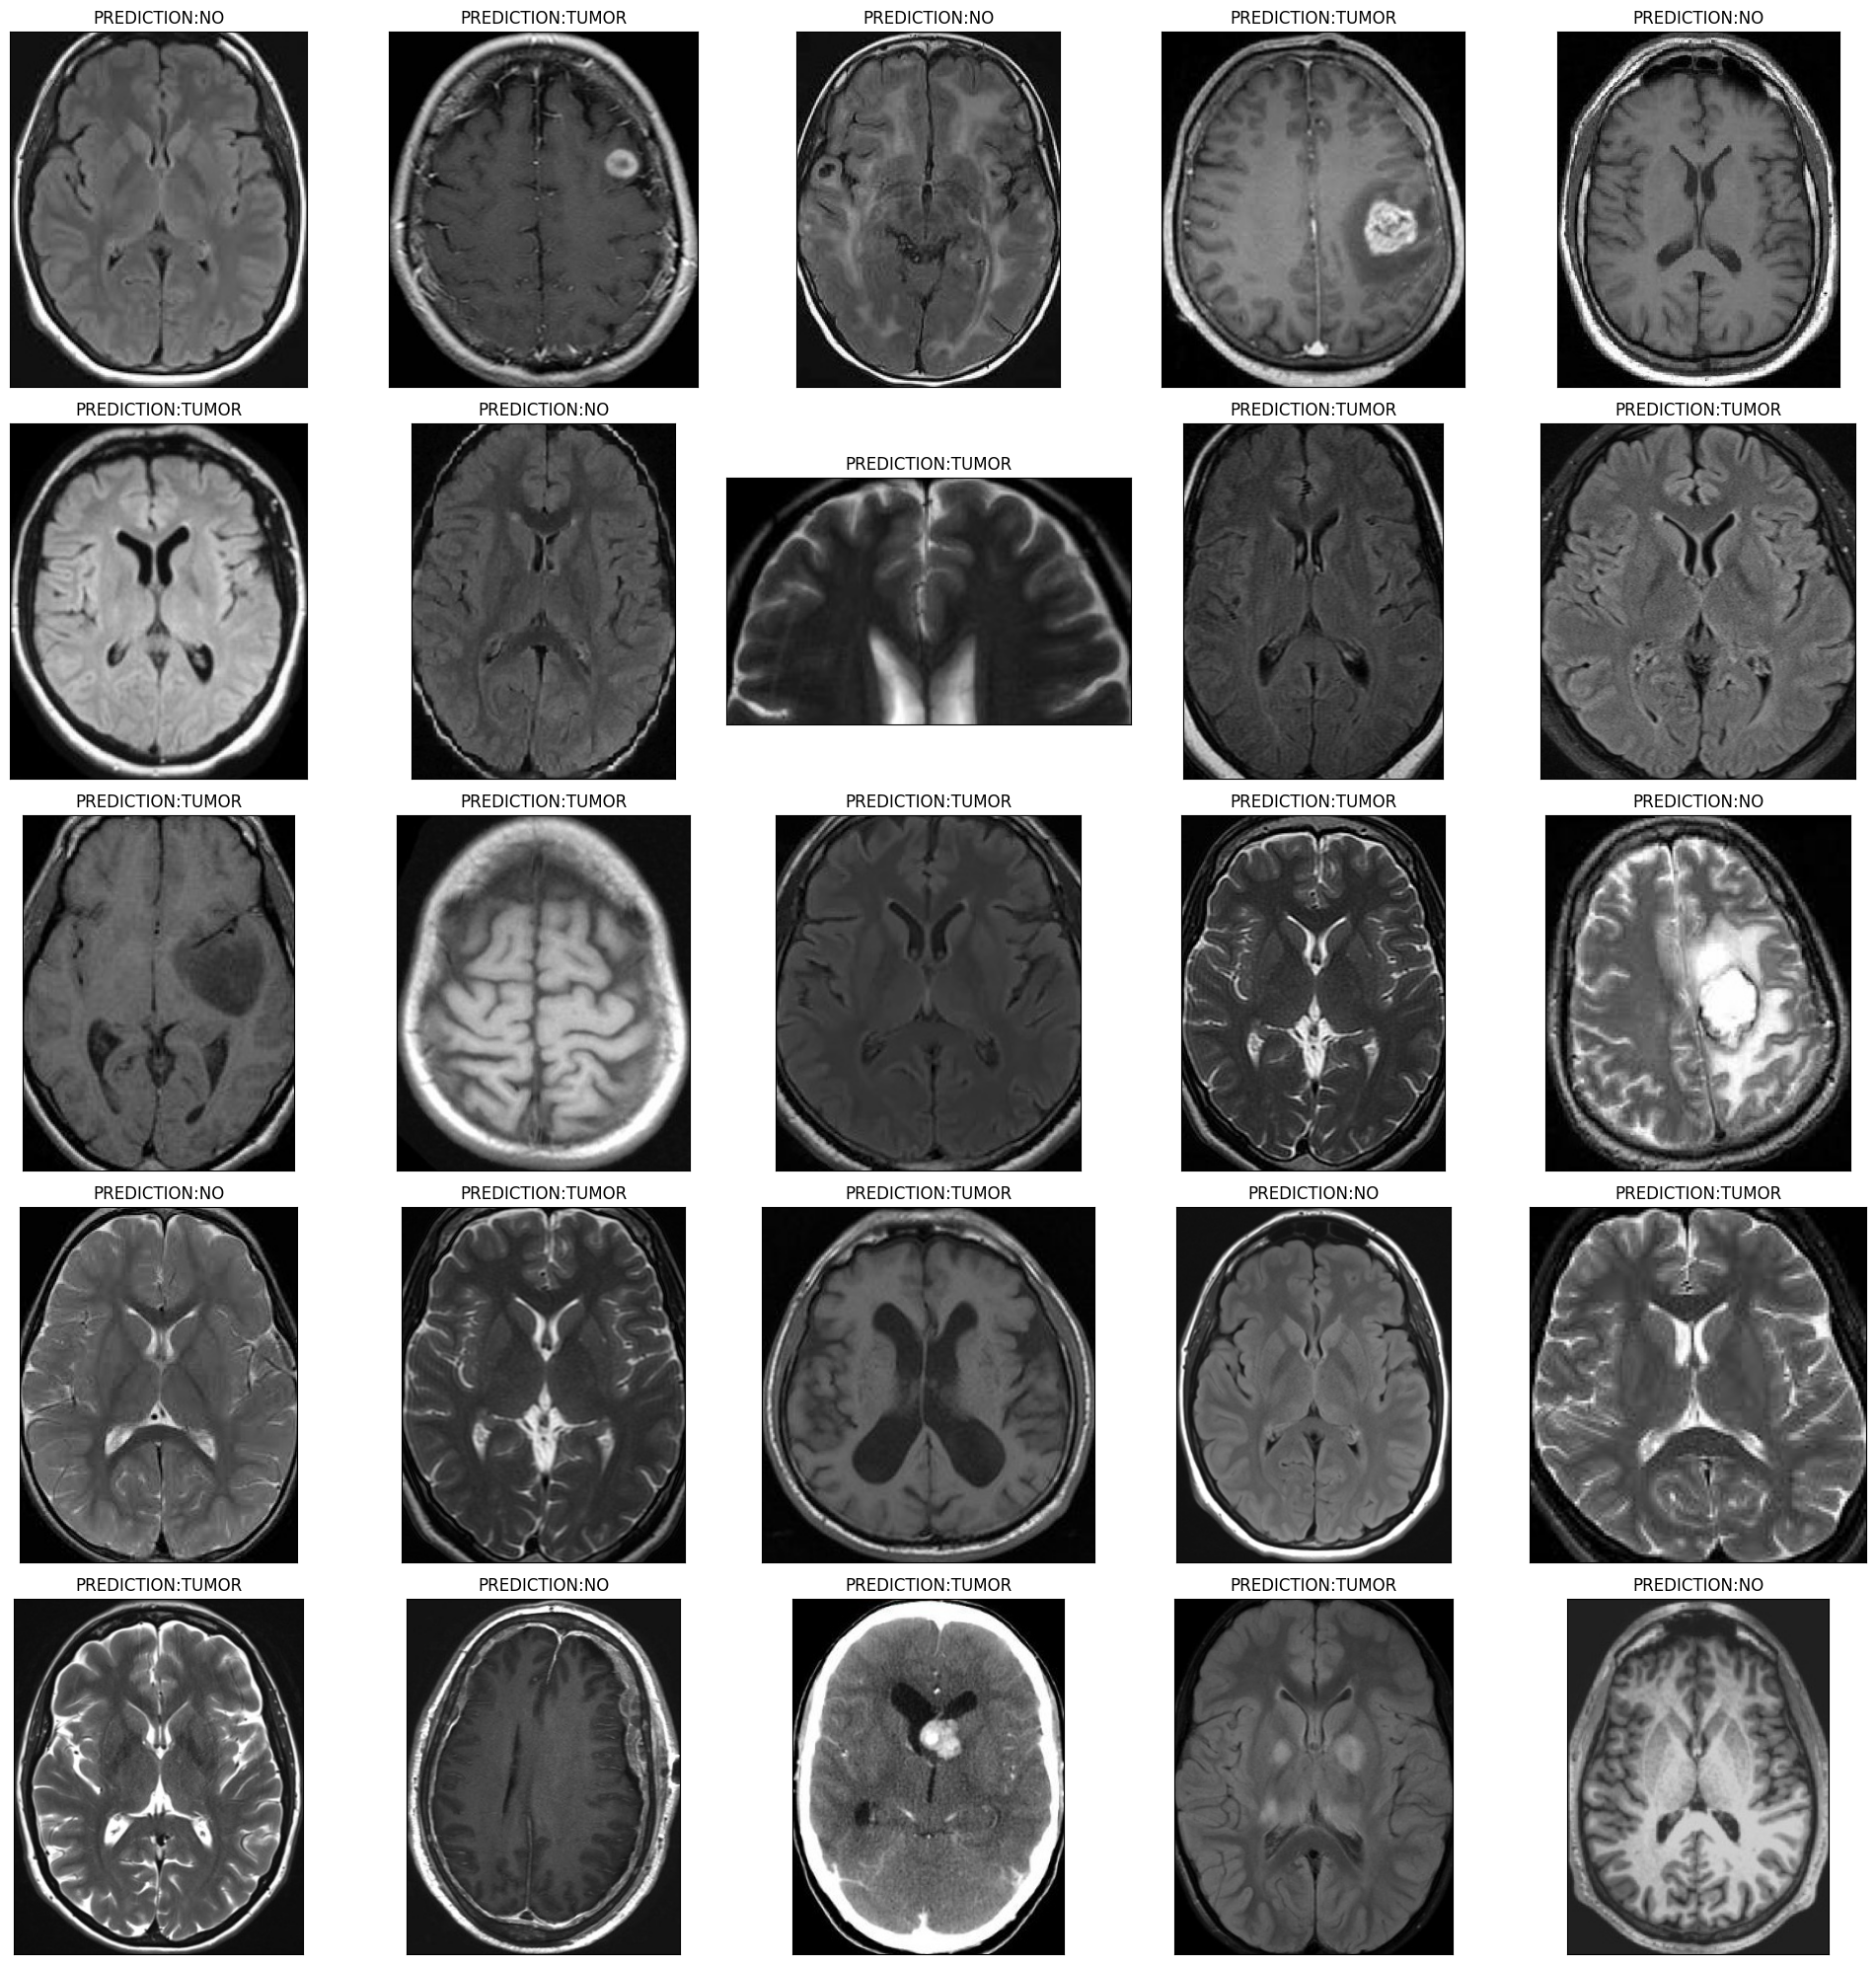

In [ ]:
fig, axes = plt.subplots(nrows=5,
                         ncols=5,
                         figsize=(20, 20),
                        subplot_kw={'xticks': [], 'yticks': []})

for i, ax in enumerate(axes.flat):
    ax.imshow(plt.imread(Main_Data_Prediction["JPG"].loc[i]))
    ax.set_title(f"PREDICTION:{Last_Prediction[i]}")
plt.tight_layout()
plt.show()

In [117]:
y_true = Test_Set.classes
y_prob = Model.predict(Test_Set)

y_pred = y_prob.argmax(axis=1)

15/15 ━━━━━━━━━━━━━━━━━━━━ 7s 442ms/step


In [118]:
print("True Labels:", y_true[:10])
print("Predicted Labels:", y_pred[:10])

True Labels: [1, 1, 0, 1, 1, 0, 1, 1, 1, 0]
Predicted Labels: [0 1 0 0 0 1 0 0 0 1]


In [120]:
class_names = list(Test_Set.class_indices.keys())

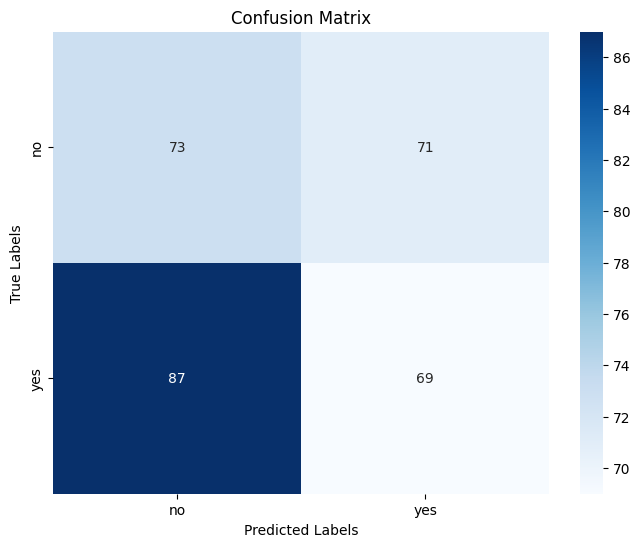

In [121]:
cm = confusion_matrix(y_true, y_pred)

plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=class_names, yticklabels=class_names)
plt.xlabel("Predicted Labels")
plt.ylabel("True Labels")
plt.title("Confusion Matrix")
plt.show()